In [28]:
%matplotlib inline

from __future__ import print_function

import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

from scipy.optimize import curve_fit

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


In [29]:
def fit_gaussian(data):
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    mean = np.mean(x)
    std = 1
    
    popt, pcov = curve_fit(gauss_function, x, y, p0 = [1, mean, std])
    
    plt.clf()
    plt.scatter(x,y)
    
    x_gauss = np.linspace(x[0], x[-1], num=1000)
    gauss = map(lambda x: gauss_function(x, popt[0], popt[1], popt[2]), x_gauss)
    plt.plot(x_gauss, gauss)
    plt.show()
    
    return(popt[1], popt[2])

In [30]:
# Find Gaussians
intervals = []

df = pd.read_csv('data/time.csv')

gaussians = []
prev = False
gaussian = []
for index,row in df.iterrows():
    if row['Counts'] > 0:
        gaussian.append((row['Channel'], row['Counts']))
        prev = True
        continue
    if row['Counts'] == 0 and prev == True:
        if len(gaussian) > 1:
            gaussians.append(gaussian)
        gaussian = []
    prev = False    

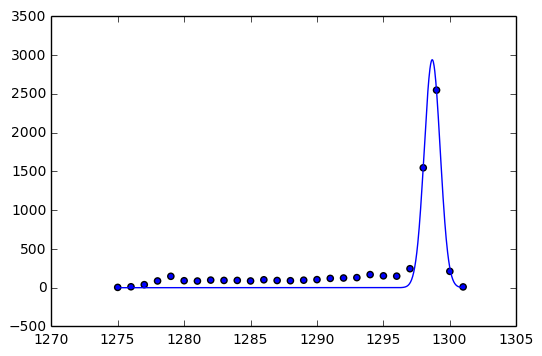

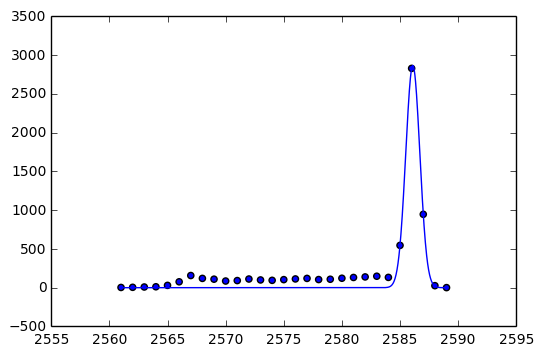

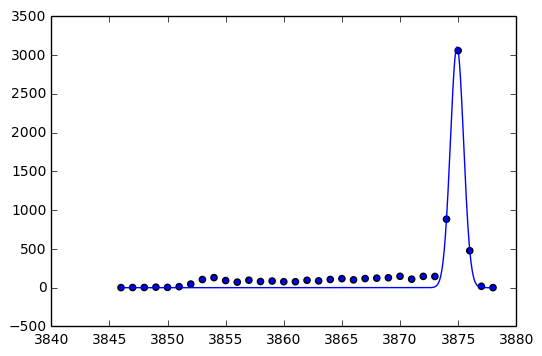

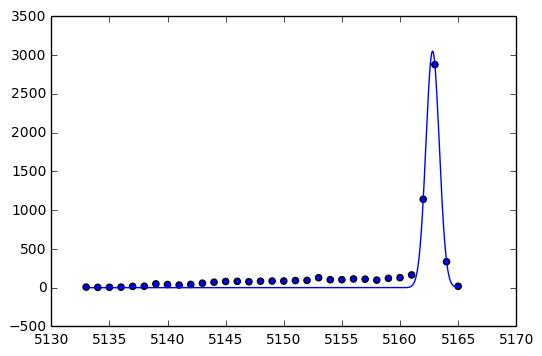

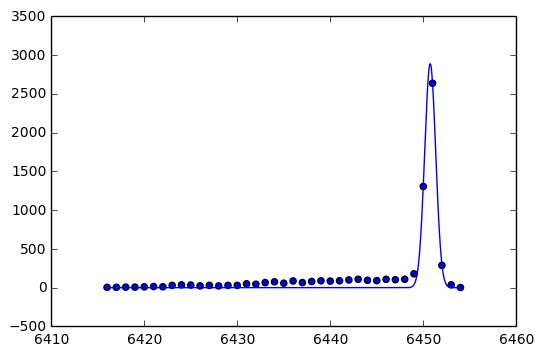

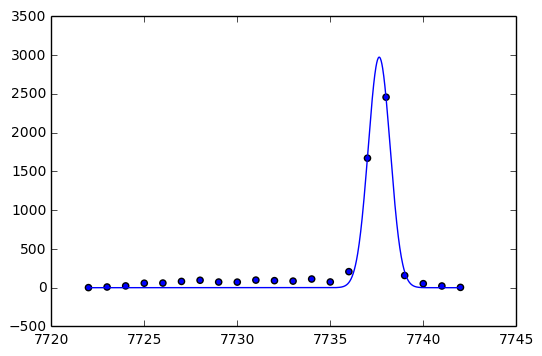

In [31]:
gaussian_means = []
gaussian_stds = []

for i in gaussians:
    stats = fit_gaussian(i)
    gaussian_means.append(stats[0])
    gaussian_stds.append(stats[1])

In [32]:
period = 0.32 # micro-seconds
times = []
for i in range(1,7): # there are 6 peaksom
    times.append(period*i)
    
print(times, gaussian_means, gaussian_stds)

[0.32, 0.64, 0.96, 1.28, 1.6, 1.92] [1298.6730000346824, 2586.0994697413812, 3874.900247526778, 5162.8017693627926, 6450.7432513908925, 7737.6299812969046] [-0.60008365319342483, 0.60534831861097205, -0.56933283313292893, 0.57360137846880455, 0.59322589185409247, -0.59172306242866457]


                            WLS Regression Results                            
Dep. Variable:                      x   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.087e+08
Date:                Tue, 03 Oct 2017   Prob (F-statistic):           5.08e-16
Time:                        14:48:14   Log-Likelihood:                 46.391
No. Observations:                   6   AIC:                            -88.78
Df Residuals:                       4   BIC:                            -89.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0027      0.000    -22.448      0.0

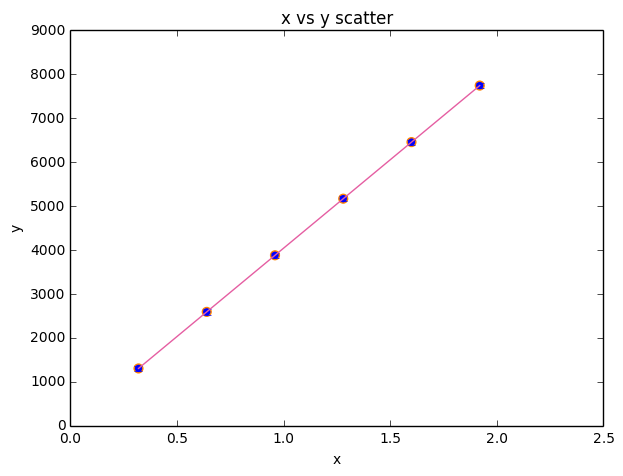

In [36]:
weights = 1/np.power(gaussian_stds, 2)

# put x and y into a pandas DataFrame, and the weights into a Series
ws = pd.DataFrame({
    'x': times,
    'y': gaussian_means,
    'yerr': map(lambda x: x * 100, gaussian_stds)
})

wls_fit = sm.wls('x ~ y', data=ws, weights=1 / weights).fit()

# show the fit summary by calling wls_fit.summary()

print(wls_fit.summary())

# let's plot our data
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w')
ws.plot(
    kind='scatter',
    x='x',
    y='y',
    yerr='yerr',
    style='o',
    alpha=1.,
    ax=ax,
    title='x vs y scatter',
    edgecolor='#ff8300',
    s=40
)

# weighted prediction
wp, = ax.plot(
    wls_fit.predict(),
    ws['y'],
    color='#e55ea2',
    lw=1.,
    alpha=1.0,
)

plt.tight_layout()
fig.set_size_inches(6.40, 5.12)
plt.savefig("so.png", dpi=100, alpha=True)
plt.show()
